In [1]:
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import datetime
from sklearn.metrics import roc_auc_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, make_scorer
import warnings
import os
import time
import datetime
import joblib
import pickle
import hashlib
from dotenv import load_dotenv
import psycopg2
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')

---
# Load and Cleaning Data
---

In [2]:
# Load environment variables
load_dotenv()

# Database connection details
db_host = os.getenv('DB_HOST_MODEL')
db_port = os.getenv('DB_PORT_MODEL')
db_user = os.getenv('DB_USER_MODEL')
db_password = os.getenv('DB_PASSWORD_MODEL')
db_name = os.getenv('DB_NAME_MODEL')

In [3]:
def load_data_from_db(query):
    """Load data from PostgreSQL database using a SQL query."""
    try:
        # Establish a connection to the database
        with psycopg2.connect(
            host=db_host,
            port=db_port,
            dbname=db_name,
            user=db_user,
            password=db_password
        ) as conn:
            # Execute the query and load data into a DataFrame
            df = pd.read_sql_query(query, conn)
            print('Before Drop Duplicated', df.shape)
            
            # Drop duplicates
            df = df.drop_duplicates(keep='first')
            print('After Drop Duplicated', df.shape)
        
        return df
    except psycopg2.OperationalError as e:
        print(f"OperationalError connecting to the database: {e}")
    except Exception as e:
        print(f"Error connecting to the database: {e}")
    
    # Return an empty DataFrame in case of error
    return pd.DataFrame()

In [4]:
# load data
query = 'SELECT * FROM "pms"."a6_02_risk_register";'
df = load_data_from_db(query)

df.head(2)

Before Drop Duplicated (58279, 42)
After Drop Duplicated (58279, 42)


,cut_off_date,project_definition,int_or_gen,r_o_type,risk_code,identification_date,description,cause,impact_consequences,initial_overall_impact,...,overall_status,log,id_postgre,top_risk_selected,created_by,modified_by,modified,risk_occured,predicted_category,CATEGORY FOR PREDICTION
0,2023-05-05,05-S9773-SALAK BRINE HEAT REC BINARY POWER PLANT,GEN,Risk,9773-R-00137,2023-04-14,Master list not obtained on timely,Unproper Prepratrion to prepare and ML submiss...,( Lead to Demurage and or Custom duty payment)...,3,...,CLOSED,On 45030 : Risk Created by Amelia,976748,false,PMIS Admin,Filycia Renatha,2023-04-14,None,None,other
1,2023-05-05,05-S9773-SALAK BRINE HEAT REC BINARY POWER PLANT,GEN,Opportunity,9773-R-00142,2023-04-14,Opportunity as deviate from Original Scope,Cutting at BHRP area delayed,Opprotunity to claimed,4,...,CLOSED,On 14-04-2023 : Risk Created by Amelia,976448,false,PMIS Admin,Filycia Renatha,2023-04-14,None,None,scope


In [5]:
selected_data = df[['description', 'cause','impact_consequences', 'CATEGORY FOR PREDICTION']]
selected_data.head()

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
0,Master list not obtained on timely,Unproper Prepratrion to prepare and ML submiss...,( Lead to Demurage and or Custom duty payment)...,other
1,Opportunity as deviate from Original Scope,Cutting at BHRP area delayed,Opprotunity to claimed,scope
2,Opportunity as deviate from Original Scope,Dumping Soil stabilization requirement due to ...,To be claimed as deviation / Changes request,scope
3,Vendor Document Register List for quality is n...,1. There is no requirement VDRL quality on RFQ...,"Lack of inspection activity, potential produc...",scope
4,Opportunity for CO request for SEG Houseload w...,Additional houseload CO request,(may delay completion of the base scope),scope


In [6]:
def remove_digits(text):
    """
    Remove digits from text

    Parameters:
    -----------
    text: str
        Input text

    Return:
    -------
    str
        Text after removing digits
    """
    if isinstance(text, str):
        return re.sub(r'\d', '', text)
    else:
        return text

In [7]:
columns_to_clean = ['description', 'cause', 'impact_consequences']
selected_data[columns_to_clean] = selected_data[columns_to_clean].applymap(remove_digits)

In [8]:
# validation digits
columns_to_check = ['description', 'cause', 'impact_consequences']

if not selected_data[columns_to_check].astype(str).apply(lambda x: x.str.contains('\d').any()).any():
    print("Columns do not contain digits.")
else:
    print("One or more columns contain digits.")

Columns do not contain digits.


In [9]:
import string

def remove_punctuation(text):
    """
    Function for removing punctuation from text while retaining spaces.

    Parameters:
    -----------
    text: str
        Input text.

    Return:
    -------
    str
        Text after removing punctuation.
    """
    if isinstance(text, str):
  
        # Use regular expression to remove punctuation but retain spaces
        text_without_punctuation = re.sub(rf'[{re.escape(string.punctuation)}]', '', text)
        
        # Ensure extra spaces are not removed during punctuation removal
        text_without_punctuation = re.sub(r'\s+', ' ', text_without_punctuation).strip()
        return text_without_punctuation
        
    else:
        return text

In [10]:
selected_data[columns_to_clean] = selected_data[columns_to_clean].applymap(remove_punctuation)

In [11]:
# validation punctuation
if not isinstance(selected_data[columns_to_clean], str):
    print("Columns do not contain punctuation.")
else:
    print("Column has punctuation")

Columns do not contain punctuation.


In [12]:
# Convert all text in string columns to lowercase
selected_data = selected_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [13]:
selected_data.head()

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
0,master list not obtained on timely,unproper prepratrion to prepare and ml submission,lead to demurage and or custom duty payment co...,other
1,opportunity as deviate from original scope,cutting at bhrp area delayed,opprotunity to claimed,scope
2,opportunity as deviate from original scope,dumping soil stabilization requirement due to ...,to be claimed as deviation changes request,scope
3,vendor document register list for quality is n...,there is no requirement vdrl quality on rfq qu...,lack of inspection activity potential product ...,scope
4,opportunity for co request for seg houseload w...,additional houseload co request,may delay completion of the base scope,scope


In [14]:
selected_data['CATEGORY FOR PREDICTION'].value_counts()

CATEGORY FOR PREDICTION
contract terms    15769
other              9410
scope              3301
construction       2011
procurement        1412
technical           413
Name: count, dtype: int64

In [15]:
# check missing nulls
selected_data.isnull().sum()

description                   18
cause                        123
impact_consequences           72
CATEGORY FOR PREDICTION    25963
dtype: int64

In [16]:
# split data label and unlabel
labeled_data = selected_data[selected_data['CATEGORY FOR PREDICTION'].notnull()]
unlabeled_data = selected_data[selected_data['CATEGORY FOR PREDICTION'].isnull()]

In [17]:
# check nulls
labeled_data.isnull().sum()

description                 2
cause                      43
impact_consequences        42
CATEGORY FOR PREDICTION     0
dtype: int64

In [18]:
# drop nulls
labeled_data = labeled_data.dropna()

In [19]:
# sanicheck nulls
labeled_data.isnull().sum()

description                0
cause                      0
impact_consequences        0
CATEGORY FOR PREDICTION    0
dtype: int64

In [20]:
def is_test_value(text):
    '''Define invalid data'''
    if not isinstance(text, str):
        return False
    return text.strip().lower() == 'test' or text.strip().lower() == 'test load'

def is_single_sentence_or_word(text):
    '''Check if the text is a single sentence or word'''
    return isinstance(text, str) and len(text.split()) <= 1

def remove_invalid_rows(df, column_to_exclude):
    '''Remove invalid data while keeping the specified column intact'''
    print('Sebelum drop invalid data:', df.shape)
    
    # Simpan kolom yang akan dikecualikan
    excluded_column = df[column_to_exclude].copy()

    # Mask untuk baris yang mengandung 'test'
    mask_test = df.drop(columns=[column_to_exclude]).apply(lambda row: any(is_test_value(val) for val in row), axis=1)
    
    # Mask untuk kolom yang hanya berisi satu kalimat atau satu kata
    mask_single = df.drop(columns=[column_to_exclude]).apply(lambda row: sum(is_single_sentence_or_word(val) for val in row) > 2, axis=1)
    
    # Gabungkan kedua mask
    mask = mask_test | mask_single
    
    # Hapus baris yang memenuhi kondisi
    df_filtered = df[~mask].copy()

    # Ambil baris yang dihapus
    mask_data = df[mask].copy()
    
    # Tambahkan kolom yang dikecualikan ke DataFrame yang difilter
    df_filtered[column_to_exclude] = excluded_column[~mask].values
    
    print('Sesudah drop invalid data:', df_filtered.shape)
    
    return df_filtered, mask_data

In [21]:
column_to_exclude = 'CATEGORY FOR PREDICTION'

labeled_data, mask_data = remove_invalid_rows(labeled_data, column_to_exclude)

Sebelum drop invalid data: (32273, 4)
Sesudah drop invalid data: (31724, 4)


In [22]:
mask_data.head()

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
86,tes,tes,tes,contract terms
601,test load,test load,test load,other
678,test load,test load,test load,other
801,test load,test load,test load,other
814,test load,test load,test load,other


In [23]:
print('description data', sum(labeled_data['description'] == 'test'))
print('cause data', sum(labeled_data['cause'] == 'test'))
print('description data', sum(labeled_data['description'] == 'test'))
print('description data', sum(labeled_data['description'] == 'test load'))
print('cause data', sum(labeled_data['cause'] == 'test load'))
print('description data', sum(labeled_data['description'] == 'test load'))

description data 0
cause data 0
description data 0
description data 0
cause data 0
description data 0


In [24]:
def remove_none_rows(df, required_columns):
    '''Remove rows with any invalid (empty) data in specified columns'''
    print('Sebelum drop invalid data:', df.shape)

    # Membuat mask untuk baris yang memiliki nilai kosong di kolom yang diperlukan
    mask = df[required_columns].isnull().any(axis=1) | (df[required_columns] == '').any(axis=1)
    
    # Hapus baris yang memenuhi kondisi
    df_filtered = df[~mask].copy()

    # Ambil baris yang dihapus
    mask_data = df[mask].copy()
    
    print('Sesudah drop invalid data:', df_filtered.shape)
    
    return df_filtered, mask_data

In [25]:
required_columns = ['description', 'cause', 'impact_consequences']
labeled_data, mask_data = remove_none_rows(labeled_data, required_columns)

Sebelum drop invalid data: (31724, 4)
Sesudah drop invalid data: (31204, 4)


In [26]:
labeled_data[['description', 'cause', 'impact_consequences', 'CATEGORY FOR PREDICTION']].head()

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
0,master list not obtained on timely,unproper prepratrion to prepare and ml submission,lead to demurage and or custom duty payment co...,other
1,opportunity as deviate from original scope,cutting at bhrp area delayed,opprotunity to claimed,scope
2,opportunity as deviate from original scope,dumping soil stabilization requirement due to ...,to be claimed as deviation changes request,scope
3,vendor document register list for quality is n...,there is no requirement vdrl quality on rfq qu...,lack of inspection activity potential product ...,scope
4,opportunity for co request for seg houseload w...,additional houseload co request,may delay completion of the base scope,scope


In [27]:
mask_data[['description', 'cause', 'impact_consequences','CATEGORY FOR PREDICTION']].head()

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
1484,claim on evacuation cost during beginning of c...,,,contract terms
1942,contract warranty period will be started from ...,,,contract terms
2794,overbudget for closing open warranty claim,,,contract terms
3005,reimbursement of wht as incentive scheme usd m...,,,contract terms
3236,contract latent defect years starting from end...,,,contract terms


In [28]:
labeled_data = labeled_data[['description', 'cause', 'impact_consequences','CATEGORY FOR PREDICTION']]

In [29]:
labeled_data.head(2)

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
0,master list not obtained on timely,unproper prepratrion to prepare and ml submission,lead to demurage and or custom duty payment co...,other
1,opportunity as deviate from original scope,cutting at bhrp area delayed,opprotunity to claimed,scope


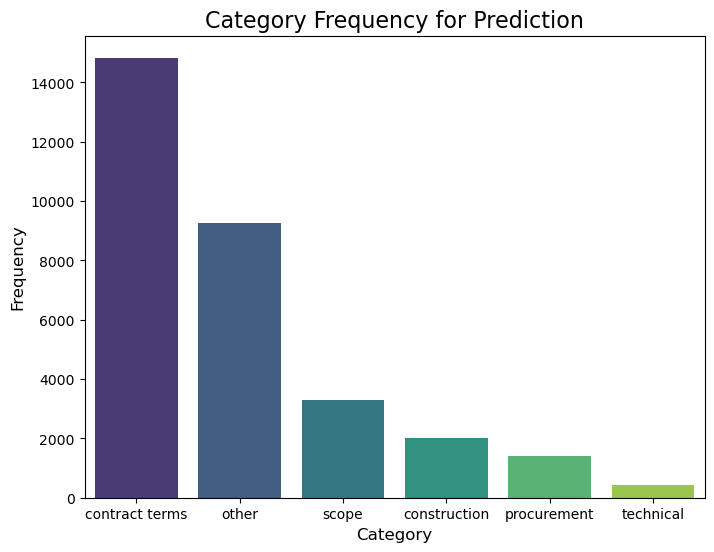

In [30]:
category_counts = labeled_data['CATEGORY FOR PREDICTION'].value_counts()

# barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Category Frequency for Prediction', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

So imbalance data!

In [31]:
import spacy

# Muat model bahasa Inggris
nlp = spacy.load('en_core_web_sm')

def remove_stop_words(text):
    """
    Menghapus kata penghubung dari teks.
    """
    doc = nlp(text)
    filtered_tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(filtered_tokens)

In [32]:
# Contoh penggunaan
text = "This is an example sentence with some stop words."
cleaned_text = remove_stop_words(text)
print(cleaned_text)

example sentence stop words


In [33]:
labeled_data['cause'] = labeled_data['cause'].apply(remove_stop_words)
labeled_data['description'] = labeled_data['description'].apply(remove_stop_words)
labeled_data['impact_consequences'] = labeled_data['impact_consequences'].apply(remove_stop_words)

In [34]:
labeled_data.head()

,description,cause,impact_consequences,CATEGORY FOR PREDICTION
0,master list obtained timely,unproper prepratrion prepare ml submission,lead demurage custom duty payment cost schedul...,other
1,opportunity deviate original scope,cutting bhrp area delayed,opprotunity claimed,scope
2,opportunity deviate original scope,dumping soil stabilization requirement mud con...,claimed deviation changes request,scope
3,vendor document register list quality submitte...,requirement vdrl quality rfq quality involve t...,lack inspection activity potential product rec...,scope
4,opportunity co request seg houseload works,additional houseload co request,delay completion base scope,scope


# Split Data
---

In [35]:
from sklearn.model_selection import train_test_split

def split_data(data, target_column):
    """
    Function for splitting data into train, test, and validation sets.

    Parameters:
    -----------
    data: pd.DataFrame
        Input data for splitting.

    Returns:
    --------
    X_train : pd.DataFrame
        Predictor data for the training set.

    X_test : pd.DataFrame
        Predictor data for the testing set.

    X_valid : pd.DataFrame
        Predictor data for the validation set.

    y_train : pd.Series
        Target data for the training set.

    y_test : pd.Series
        Target data for the testing set.

    y_valid : pd.Series
        Target data for the validation set.
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target_column]),
                                                        data[target_column],
                                                        test_size=0.2,
                                                        random_state=42)

    # Further split the test set into test and validation sets
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,
                                                        test_size=0.5,
                                                        random_state=42)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [36]:
# Call the function with your DataFrame
X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(data = labeled_data, 
                                                                target_column = 'CATEGORY FOR PREDICTION')

In [37]:
# validate
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_valid shape', X_valid.shape)
print('y_valid shape', y_valid.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (24963, 3)
y_train shape (24963,)
X_valid shape (3121, 3)
y_valid shape (3121,)
X_test shape (3120, 3)
y_test shape (3120,)


In [38]:
# change to array
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [39]:
# Nama direktori
directory = r'app\data'

# Buat direktori jika belum ada
os.makedirs(directory, exist_ok=True)

# Nama file
X_train_file = os.path.join(directory, 'X_train.pkl')
y_train_file = os.path.join(directory, 'y_train.pkl')
X_test_file = os.path.join(directory, 'X_test.pkl')
y_test_file = os.path.join(directory, 'y_test.pkl')

# Simpan X_train dan y_train ke dalam file di direktori 'data'
joblib.dump(X_train, X_train_file)
joblib.dump(y_train, y_train_file)
joblib.dump(X_test, X_test_file)
joblib.dump(y_test, y_test_file)

print("Data X_train dan y_train telah disimpan ke dalam direktori 'data'.")
print("Data X_test dan y_test telah disimpan ke dalam direktori 'data'.")

Data X_train dan y_train telah disimpan ke dalam direktori 'data'.
Data X_test dan y_test telah disimpan ke dalam direktori 'data'.


# Eksploratory Data Analysis
---

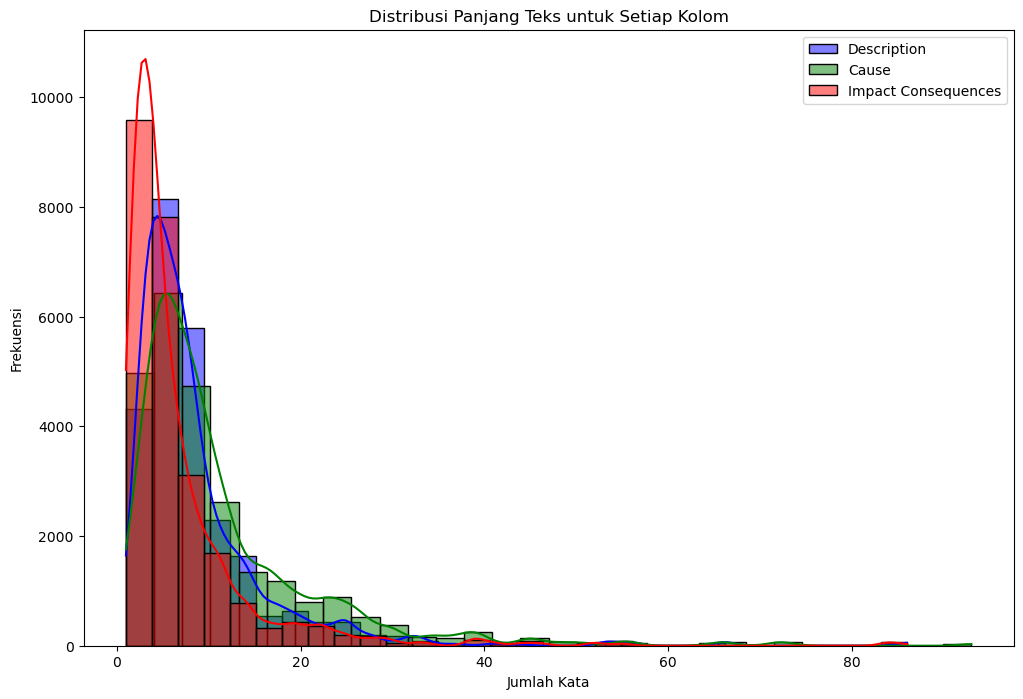

In [40]:
# Buat salinan DataFrame
X_train_copy = X_train.copy()

# Menghitung panjang teks dalam kata
X_train_copy['description_length'] = X_train_copy['description'].apply(lambda x: len(x.split()))
X_train_copy['cause_length'] = X_train_copy['cause'].apply(lambda x: len(x.split()))
X_train_copy['impact_consequences_length'] = X_train_copy['impact_consequences'].apply(lambda x: len(x.split()))

# Visualisasi panjang teks
plt.figure(figsize=(12, 8))
sns.histplot(X_train_copy['description_length'], bins=30, color='blue', label='Description', kde=True)
sns.histplot(X_train_copy['cause_length'], bins=30, color='green', label='Cause', kde=True)
sns.histplot(X_train_copy['impact_consequences_length'], bins=30, color='red', label='Impact Consequences', kde=True)
plt.legend()
plt.title('Distribusi Panjang Teks untuk Setiap Kolom')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

rata-rata model akan belajar di jumlah 15 kata dengan kata maksimum 80 kata

In [41]:
# check standartdeviasai
std_description = X_train_copy['description_length'].std()
std_cause = X_train_copy['cause_length'].std()
std_impact_consequences = X_train_copy['impact_consequences_length'].std()

print(f"Deviasi Standar Panjang Teks Description: {std_description:.2f}")
print(f"Deviasi Standar Panjang Teks Cause: {std_cause:.2f}")
print(f"Deviasi Standar Panjang Teks Impact Consequences: {std_impact_consequences:.2f}")

Deviasi Standar Panjang Teks Description: 8.32
Deviasi Standar Panjang Teks Cause: 10.45
Deviasi Standar Panjang Teks Impact Consequences: 8.01


Dari panjang kata maksimum 80 kata, dengan standartdeviasi tersebut tergolong data kita mempunya unique yang rendah

**WORD2VEC**

In [42]:
from gensim.models import Word2Vec

In [43]:
# Buat salinan DataFrame
X_train_copy2 = X_train.copy()

In [44]:
# Melatih model Word2Vec
sentences = X_train_copy2['description'].tolist() + X_train_copy2['cause'].tolist() + X_train_copy2['impact_consequences'].tolist()
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=0)

In [45]:
def get_word_vectors(text_list):
    """Mengambil representasi vektor dari daftar kata menggunakan model Word2Vec"""
    vectors = []
    # loop text
    for word in text_list:
        if word in model.wv:
            vectors.append(model.wv[word])
    return np.array(vectors)

def std_deviation_of_vector_length(text_column):
    """Menghitung deviasi standar dari panjang vektor untuk setiap kata dalam kolom teks"""

    # call function
    vectors = get_word_vectors(text_column)
    
    if vectors.size == 0:
        return 0

    # panjang vector
    vector_lengths = np.linalg.norm(vectors, axis=1)
    return np.std(vector_lengths)

In [46]:
std_description = std_deviation_of_vector_length(X_train_copy2['description'].sum())
std_cause = std_deviation_of_vector_length(X_train_copy2['cause'].sum())
std_impact_consequences = std_deviation_of_vector_length(X_train_copy2['impact_consequences'].sum())

In [47]:
print(f"Deviasi Standar Panjang Vektor Description: {std_description:.2f}")
print(f"Deviasi Standar Panjang Vektor Cause: {std_cause:.2f}")
print(f"Deviasi Standar Panjang Vektor Impact Consequences: {std_impact_consequences:.2f}")

Deviasi Standar Panjang Vektor Description: 0.89
Deviasi Standar Panjang Vektor Cause: 0.88
Deviasi Standar Panjang Vektor Impact Consequences: 0.91


Variasi kata Word2Vec memiliki hasil yang rendah artinya kata dalam kategori ini memiliki representasi yang lebih konsisten dan tidak terlalu bervariasi dalam hal vektor. Kata dalam data tergolong mirip

# Preprocessing Data
---

## Preprocessing Data Target
---

In [48]:
from sklearn.preprocessing import LabelEncoder

# initialize
ohe = LabelEncoder()

y_train = ohe.fit_transform(y_train)
y_valid = ohe.fit_transform(y_valid)
y_test = ohe.fit_transform(y_test)

In [49]:
y_train

array([1, 4, 2, ..., 2, 2, 2])

In [50]:
y_valid

array([1, 1, 2, ..., 1, 1, 2])

In [51]:
y_test

array([2, 2, 1, ..., 1, 3, 2])

In [52]:
y_train[:20]

array([1, 4, 2, 1, 1, 1, 0, 1, 1, 2, 4, 1, 2, 1, 1, 1, 0, 2, 1, 2])

## Preprocessing Data Predictor
---

- TF-IDF
- Bag of Words / Count Vectorizer

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
def tfid(df, columns):
    '''Fit data to TF-IDF Vectorizer from multiple text columns in a DataFrame'''
    # Combine specified columns into a single text document per row
    text_data = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    # Create and fit the TF-IDF vectorizer on the combined text data
    tfidf = TfidfVectorizer()
    tfidf.fit(text_data)
    
    # Transform the data
    transform = tfidf.transform(text_data)
    
    # Print the shape of the transformed data
    print(f'Shape of transformed data: {transform.shape}')
    
    # Print the vocabulary size and feature names
    print('Vocabulary size:', len(tfidf.get_feature_names_out()))
    print('Sample features:', tfidf.get_feature_names_out())
    
    # Return the transformed data and the vectorizer
    return transform, tfidf

In [55]:
def transform_tfid(vectorizer, df, columns):
    '''Transform data using a pre-fitted TF-IDF Vectorizer'''
    # Combine specified columns into a single text document per row
    text_data = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    # Transform the data
    transform = vectorizer.transform(text_data)
    
    # Print the shape of the transformed data
    print(f'Shape of transformed data: {transform.shape}')
    
    # Return the transformed data
    return transform

In [56]:
# Fit the TF-IDF vectorizer on the training data
X_train_tfid, vectorizer_tfidf = tfid(X_train, ['cause', 'impact_consequences', 'description'])

# Transform the training, validation, and test data using the pre-fitted TF-IDF vectorizer
X_valid_tfid = transform_tfid(vectorizer_tfidf, X_valid, ['cause', 'impact_consequences', 'description'])
X_test_tfid = transform_tfid(vectorizer_tfidf, X_test, ['cause', 'impact_consequences', 'description'])

Shape of transformed data: (24963, 4582)
Vocabulary size: 4582
Sample features: ['aace' 'ab' 'abandonment' ... 'zealand' 'zekon' 'zone']
Shape of transformed data: (3121, 4582)
Shape of transformed data: (3120, 4582)


In [57]:
def bow(df, columns):
    '''Fit data to Bag of Words / Count Vectorizer from multiple text columns in a DataFrame'''
    # Combine specified columns into a single text document per row
    text_data = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    # Create and fit the vectorizer on the combined text data
    vectorizer = CountVectorizer()
    vectorizer.fit(text_data)
    
    # Transform the data
    transform = vectorizer.transform(text_data)
    
    # Print the shape of the transformed data
    print(f'Shape of transformed data: {transform.shape}')
    
    # Print the vocabulary size and feature names
    print('Vocabulary size:', len(vectorizer.get_feature_names_out()))
    print('Sample features:', vectorizer.get_feature_names_out())
    
    return transform, vectorizer

In [58]:
def transform_bow(vectorizer, df, columns):
    '''Transform data using a pre-fitted Count Vectorizer'''
    # Combine specified columns into a single text document per row
    text_data = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    # Transform the data
    transform = vectorizer.transform(text_data)
    
    # Print the shape of the transformed data
    print(f'Shape of transformed data: {transform.shape}')
    
    # Return the transformed data
    return transform

In [59]:
# Fit the Count Vectorizer on the training data
X_train_bow, vectorizer_bow = bow(X_train, ['cause', 'impact_consequences', 'description'])

# Transform the training, validation, and test data using the pre-fitted Count Vectorizer
X_valid_bow = transform_bow(vectorizer_bow, X_valid, ['cause', 'impact_consequences', 'description'])
X_test_bow = transform_bow(vectorizer_bow, X_test, ['cause', 'impact_consequences', 'description'])

Shape of transformed data: (24963, 4582)
Vocabulary size: 4582
Sample features: ['aace' 'ab' 'abandonment' ... 'zealand' 'zekon' 'zone']
Shape of transformed data: (3121, 4582)
Shape of transformed data: (3120, 4582)


# Modeling
---

In [60]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier # RusBoost model
from sklearn.ensemble import RandomForestClassifier # RusBoost model
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, ClassifierMixin

**Create a logger**

In [61]:
def time_stamp():
    return datetime.datetime.now()

def create_log_template():
    """
    Create a template for the training log.

    Parameters :
    ------------
    None

    Returns :
    ---------
        dict: A dictionary template for the training log.
    """
    return {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "Macro-Averaged F1 Score": [],
        "ROC AUC": [],
        "Balanced Accuracy": [],
        "data_configurations": [],
    }

def training_log_updater(logger, log_path):
    """
    Update the training log with the provided logger and save it to a JSON file.

    Parameters:
    -----------
    logger : dict
        Dictionary containing training log information.

    log_path : str
        File path where the training log will be saved in JSON format.

    Returns:
    --------
    pd.DataFrame
        DataFrame representing the updated training log.
    """
    # Convert the new log (logger) to a DataFrame
    new_log = pd.DataFrame(logger)

    # Check if the log file already exists
    if os.path.exists(log_path):
        # Read the existing log file
        existing_log = pd.read_json(log_path, orient="records", lines=True)
        
        # Append the new log to the existing log
        updated_log = pd.concat([existing_log, new_log], ignore_index=True)
    else:
        # If the file doesn't exist, start with the new log
        updated_log = new_log

    # Save the updated log back to the file
    updated_log.to_json(log_path, orient="records", lines=True)

    return updated_log

def generate_model_uid(model):
    """
    Generate a unique identifier for a model based on its parameters.

    Parameters:
    -----------
    model : object
        The machine learning model.

    Returns:
    --------
    str
        A unique identifier for the model.
    """
    model_info = str(model.get_params())  
    return hashlib.md5(model_info.encode()).hexdigest()

In [62]:
class EUSBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=50, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.random_state = random_state
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weights_dict = dict(zip(np.unique(y), class_weights))
        
        self.estimators_ = []
        self.alpha_ = []
        
        # Initialize weights
        sample_weights = np.ones(n_samples) / n_samples
        
        for t in range(self.n_estimators):
            # Fit the base estimator
            estimator = self.base_estimator
            estimator.fit(X, y, sample_weight=sample_weights)
            
            # Compute the predictions
            y_pred = estimator.predict(X)
            
            # Compute the error
            error = np.sum(sample_weights * (y_pred != y)) / np.sum(sample_weights)
            
            # Compute alpha
            alpha = np.log((1 - error) / (error + 1e-10))  # avoid division by zero
            self.estimators_.append(estimator)
            self.alpha_.append(alpha)
            
            # Update sample weights
            sample_weights *= np.exp(alpha * (y_pred != y))
            sample_weights /= np.sum(sample_weights)
        
        return self
    
    def predict(self, X):
        # Aggregate the predictions from the base estimators
        pred_sum = np.zeros(X.shape[0])
        for estimator, alpha in zip(self.estimators_, self.alpha_):
            pred_sum += alpha * estimator.predict(X)
        
        return np.sign(pred_sum)
    
    def predict_proba(self, X):
        # Initialize probability sums
        prob_sum = np.zeros((X.shape[0], self.estimators_[0].predict_proba(X).shape[1]))
        for estimator, alpha in zip(self.estimators_, self.alpha_):
            prob_sum += alpha * estimator.predict_proba(X)
        
        # Normalize probabilities
        prob_sum = prob_sum / np.sum(self.alpha_)
        
        # Ensure probabilities sum to 1
        prob_sum = np.clip(prob_sum, 0, 1)
        row_sums = prob_sum.sum(axis=1, keepdims=True)
        prob_sum /= row_sums
        
        return prob_sum

In [63]:
# List of models
model_base = OneVsRestClassifier(DummyClassifier(strategy='most_frequent'))
model_ada = OneVsRestClassifier(AdaBoostClassifier())
model_eusboost = OneVsRestClassifier(EUSBoost(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42))
model_rus_boost = OneVsRestClassifier(RUSBoostClassifier(random_state=42))
model_rf = OneVsRestClassifier(RandomForestClassifier(max_depth=5))
model_xg = OneVsRestClassifier(XGBClassifier())

In [64]:
list_of_models = {
    "TFID": [
        {"model_name": model_base.__class__.__name__, "model_object": model_base, "model_uid": ""},
        {"model_name": model_ada.__class__.__name__, "model_object": model_ada, "model_uid": ""},
        {"model_name": model_eusboost.__class__.__name__, "model_object": model_eusboost, "model_uid": ""},
        {"model_name": model_rus_boost.__class__.__name__, "model_object": model_rus_boost, "model_uid": ""},
        {"model_name": model_rf.__class__.__name__, "model_object": model_rf, "model_uid": ""},
        {"model_name": model_xg.__class__.__name__, "model_object": model_xg, "model_uid": ""}
    ],
    "BOW": [
        {"model_name": model_base.__class__.__name__, "model_object": model_base, "model_uid": ""},
        {"model_name": model_ada.__class__.__name__, "model_object": model_ada, "model_uid": ""},
        {"model_name": model_eusboost.__class__.__name__, "model_object": model_eusboost, "model_uid": ""},
        {"model_name": model_rus_boost.__class__.__name__, "model_object": model_rus_boost, "model_uid": ""},
        {"model_name": model_rf.__class__.__name__, "model_object": model_rf, "model_uid": ""},
        {"model_name": model_xg.__class__.__name__, "model_object": model_xg, "model_uid": ""}
    ]
}

## Training Model
---

In [65]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, log_path):
    """
    Train and evaluate a list of machine learning models, update a training log, and save the log to a file.

    Parameters :7
    ------------
    list_of_model : list 
        List of dictionaries containing model information.

    prefix_model_name : str 
        Prefix to be added to each model name for identification.

    x_train : array-like 
        Input features for training.

    y_train : array-like 
        Target values for training.

    data_configuration_name : str
        Description of the data configuration used for training.

    log_path : str 
        File path where the training log will be saved.

    Returns :
    ---------
        tuple: A tuple containing the file path of the saved training log and the updated list of models.
    """
    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):
        # Extract base classifier name
        base_classifier_name = model["model_object"].estimator.__class__.__name__
        model_name = prefix_model_name + "-" + base_classifier_name

        # Handle specific model requirements for data conversion
        if base_classifier_name in ['KNeighborsClassifier', 'DecisionTreeClassifier', 'GaussianNB']:
            x_train_transformed = x_train.toarray() if hasattr(x_train, 'toarray') else x_train
        else:
            x_train_transformed = x_train

        # Fit the model
        start_time = time_stamp()
        model["model_object"].fit(x_train_transformed, y_train)
        finished_time = time_stamp()

        # Convert to seconds
        elapsed_time = (finished_time - start_time).total_seconds()

        # Use predictions on the training data
        y_pred = model["model_object"].predict(x_train_transformed)
        y_pred_prob = model["model_object"].predict_proba(x_train_transformed)[:, 1]  # Probabilities for ROC AUC

        # Calculate Macro-Averaged F1 Score
        macro_f1 = f1_score(y_train, y_pred, average='macro')

        # Handle ROC AUC Calculation
        try:
            if len(np.unique(y_train)) == 2:  # Binary classification
                roc_auc = roc_auc_score(y_train, y_pred_prob)
            else:  # Multiclass classification
                roc_auc = roc_auc_score(y_train, model["model_object"].predict_proba(x_train_transformed), multi_class='ovr')
        except ValueError as e:
            roc_auc = np.nan  # Handle cases where ROC AUC cannot be computed

        # Calculate Balanced Accuracy
        balanced_acc = balanced_accuracy_score(y_train, y_pred)

        # Create a unique identifier (one-way encryption)
        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        # Add to the logger
        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["Macro-Averaged F1 Score"].append(macro_f1)
        logger["ROC AUC"].append(roc_auc)
        logger["Balanced Accuracy"].append(balanced_acc)
        logger["data_configurations"].append(data_configuration_name)

    # Update the training log and save to a file
    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [66]:
# Define the log directory path
log_dir = 'logs'

# Ensure the directory exists,
os.makedirs(log_dir, exist_ok=True)

# log path
log_path = os.path.join(log_dir, 'training_log.json')

### Model Data 1
---

In [67]:
# TFID
training_log_tfid, list_of_model_tfid = train_eval_model(
                                                    list_of_model=list_of_models['TFID'],
                                                    prefix_model_name='Best_Model',
                                                    x_train=X_train_tfid,
                                                    y_train=y_train,
                                                    data_configuration_name="TFID Data",
                                                    log_path=log_path
                                                )

list_of_models["TFID"] = copy.deepcopy(list_of_model_tfid)

100%|██████████| 6/6 [09:51<00:00, 98.64s/it] 


### Model Data 2
---

In [68]:
# BOW
training_log_bow, list_of_model_bow= train_eval_model(
                                                    list_of_model=list_of_models['BOW'],
                                                    prefix_model_name='Best_Model',
                                                    x_train=X_train_bow,
                                                    y_train=y_train,
                                                    data_configuration_name="BOW Data",
                                                    log_path=log_path
                                                )

list_of_models["BOW"] = copy.deepcopy(list_of_model_bow)

100%|██████████| 6/6 [06:57<00:00, 69.54s/it] 


## Best Model Data Train
---

In [69]:
def join_log_predict(list_of_training_logs, sort_metric):
    """
    Combine multiple training logs into a single DataFrame, remove duplicates, and sort it based on the specified metric and training time.

    Parameters:
    -----------
    list_of_training_logs : list
        List of DataFrames representing individual training logs.

    sort_metric : str
        The metric based on which the combined log should be sorted.

    Returns:
    --------
    pd.DataFrame
        Combined, deduplicated, and sorted training log.
    """
    # Combine multiple training logs into a single DataFrame
    combined_log = pd.concat(list_of_training_logs)

    # Remove duplicates based on 'model_uid' and 'data_configurations'
    combined_log.drop_duplicates(subset=['model_uid', 'data_configurations'], keep='first', inplace=True)

    # Sort the combined log based on the specified metric and training time
    if sort_metric in combined_log.columns:
        combined_log.sort_values(by=[sort_metric, 'training_time'], ascending=[True, True], inplace=True)
    else:
        raise ValueError(f"{sort_metric} not found in the training log columns.")

    # Reset the index
    combined_log.reset_index(drop=True, inplace=True)

    return combined_log

In [70]:
from datetime import datetime, timedelta

def filter_and_sort_training_logs(list_of_training_logs, sort_metric='Macro-Averaged F1 Score'):
    """Filter log data for obtained base model and remove duplicates."""
    
    # Combine all log data 
    combined_df = pd.concat(list_of_training_logs, ignore_index=True)
    
    # Convert 'training_date' to datetime
    combined_df['training_date'] = pd.to_datetime(combined_df['training_date'])
    
    # Filter for the last 7 days
    end_date = datetime.now()
    start_date = end_date - timedelta(days=3)
    recent_df = combined_df[(combined_df['training_date'] >= start_date) & (combined_df['training_date'] <= end_date)]
    
    # Drop duplicates 
    recent_df = recent_df.drop_duplicates(subset=['model_name', 'training_date'], keep='last')
    
    # Sort based on the specified metric
    sorted_df = recent_df.sort_values(by=sort_metric, ascending=False).reset_index(drop=True)
    
    return sorted_df

In [71]:
# Set list training logs
list_of_training_logs = [training_log_tfid, training_log_bow]

# Panggil fungsi
training_res = filter_and_sort_training_logs(list_of_training_logs, sort_metric='Macro-Averaged F1 Score')
training_res

,model_name,model_uid,training_time,training_date,Macro-Averaged F1 Score,ROC AUC,Balanced Accuracy,data_configurations
0,Best_Model-XGBClassifier,4ccfa3765ba89aef73254e3f47fdb686,2.737681,2024-09-26 14:29:00.395469,0.903459,0.990546,0.894313,TFID Data
1,Best_Model-XGBClassifier,fe7f7a07e231a2e844bae1b95558d53a,1.454881,2024-09-26 14:35:59.062185,0.898148,0.989233,0.887900,BOW Data
2,Best_Model-AdaBoostClassifier,d46116f033c359b40c213574ce6496a6,9.725419,2024-09-26 14:19:11.662780,0.810657,0.829134,0.775771,TFID Data
3,Best_Model-EUSBoost,86be84364a1d8c683d1b7faaaa4431c8,385.719132,2024-09-26 14:29:13.746803,0.796540,0.980975,0.796025,BOW Data
4,Best_Model-EUSBoost,28d581a0df308d7d32d620388fbf9534,548.841999,2024-09-26 14:19:26.647830,0.796540,0.980975,0.796025,TFID Data
5,Best_Model-AdaBoostClassifier,c9ddd5da6a0b0273a88675a5c7acd991,6.861668,2024-09-26 14:29:03.650359,0.783775,0.839099,0.742325,BOW Data
6,Best_Model-RUSBoostClassifier,3f94d18305088db24b1e4e7a0a032bc3,6.854017,2024-09-26 14:28:44.160358,0.718510,0.798244,0.805611,TFID Data
7,Best_Model-RUSBoostClassifier,c144fc0fdf1e440ee8f63de98a3dbed4,5.316205,2024-09-26 14:35:46.572546,0.707339,0.794652,0.788384,BOW Data
8,Best_Model-RandomForestClassifier,44ea681cec454ecb6ceeacf9d804f30b,2.070717,2024-09-26 14:35:55.295406,0.345772,0.946333,0.317952,BOW Data
9,Best_Model-RandomForestClassifier,963b1b3a109fe49faa64236fe812521c,2.377110,2024-09-26 14:28:56.342424,0.328362,0.954544,0.308020,TFID Data


In [72]:
def convert_to_dict(df):
    """
    Convert a DataFrame to a dictionary format where each key is a configuration
    and each value is a list of model data dictionaries.
    """
    # initialize
    model_dict = {}

    # loop logging
    for _, row in df.iterrows():
        config = row['data_configurations']
        if config not in model_dict:
            
            model_dict[config] = []
        
        model_dict[config].append({
            "model_uid": row['model_uid'],
            "model_object": row['model_name'],  
            "data_configurations": row['data_configurations'],
            "training_time": row['training_time'],
            "training_date": row['training_date'],
            "Macro-Averaged F1 Score": row['Macro-Averaged F1 Score'],
            "ROC AUC": row['ROC AUC'],
            "Balanced Accuracy": row['Balanced Accuracy']
        })
        
    return model_dict

In [73]:
# Convert the DataFrame to the dictionary
list_of_model = convert_to_dict(training_res)

In [74]:
def get_best_model(training_log_df, list_of_model, sort_metrics, minimize=False):
    """
    Get the top 3 performing models based on a given training log and sort metrics.

    Parameters:
    -----------
    training_log_df : pd.DataFrame
        DataFrame representing the training log.

    list_of_model : dict
        Dictionary containing a list of models for different configurations.

    sort_metrics : list of str
        List of metrics based on which the top models should be determined.

    minimize : bool, default=False
        Whether to minimize the sort_metrics. Set to True if the metrics should be minimized.

    Returns:
    --------
    top_3_models_info : list of dict
        A list of dictionaries, each containing a top-performing model object, its configuration data, and additional information.
    """
    # Determine sorting order: ascending for minimization, descending for maximization
    ascending = minimize

    # Sort by the specified sort_metrics and training_time as a tiebreaker
    sorted_log = training_log_df.sort_values(by=sort_metrics + ['training_time'], ascending=[ascending] * len(sort_metrics) + [True])

    # Pick the top 3 models based on the sorted metrics
    top_2_log = sorted_log.head(2)

    top_2_models_results = []

    for _, best_model_info in top_2_log.iterrows():
        # Find the model in the list_of_model
        model_object = None
        data_configuration = None
        
        for configuration_data in list_of_model:
            for model_data in list_of_model[configuration_data]:
                if model_data["model_uid"] == best_model_info["model_uid"]:
                    model_object = model_data["model_object"]
                    data_configuration = best_model_info["data_configurations"]
                    break

        if model_object is None:
            raise RuntimeError(f"The model with UID {best_model_info['model_uid']} was not found in your list of models.")
        
        # Append the model object and its configuration to the results list
        top_2_models_results.append({
            "model_object": model_object,
            "data_configuration": data_configuration,
            "best_model_info": best_model_info.to_dict()
        })
    
    return top_2_models_results

In [75]:
result = get_best_model(
    training_log_df=training_res,
    list_of_model=list_of_model,
    sort_metrics=['Macro-Averaged F1 Score', 'Balanced Accuracy', 'ROC AUC']
)

# initialize
models_info_list = []

for model_info in result:
    models_info_list.append(model_info["best_model_info"])

# dataframe
models_info_df = pd.DataFrame(models_info_list)

models_info_df.head()

,model_name,model_uid,training_time,training_date,Macro-Averaged F1 Score,ROC AUC,Balanced Accuracy,data_configurations
0,Best_Model-XGBClassifier,4ccfa3765ba89aef73254e3f47fdb686,2.737681,2024-09-26 14:29:00.395469,0.903459,0.990546,0.894313,TFID Data
1,Best_Model-XGBClassifier,fe7f7a07e231a2e844bae1b95558d53a,1.454881,2024-09-26 14:35:59.062185,0.898148,0.989233,0.887900,BOW Data


### Cross Validation & Re-Train with Data Train
---

In [77]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate

In [79]:
def hyperparameter_tuning(best_model_info):
    """
    Perform hyperparameter tuning using RandomizedSearchCV for a specified model.

    Parameters:
    ----------
    best_model_info : dict
        A dictionary containing information about the best model. 
        The key 'model_name' is expected to contain the name of the model as a string.

    Returns:
    -------
    best_params_ : dict
        Dictionary of the best hyperparameters found during the search.
        
    best_scores_ : dict
        Dictionary containing the best scores achieved with the best parameters for each metric.
        
    Raises:
    ------
    KeyError
        If 'model_name' is not present in best_model_info.
        
    ValueError
        If the specified model in 'model_name' is not supported.

    Exception
        For any other error that occurs during the search process.
    """
    try:
        # Extract model name and data configurations
        model_name = best_model_info['model_name']
        data_configurations = best_model_info['data_configurations']
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Select data train
        if 'BOW Data' in data_configurations:
            X_train = X_train_bow
        elif 'TFID Data' in data_configurations:
            X_train = X_train_tfid
        else:
            raise ValueError("Data configuration not recognized.")

        if "AdaBoostClassifier" in model_name:
            params_grid = {
                'estimator__n_estimators': [50, 100, 200, 300],
                'estimator__learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0],
                'estimator__algorithm': ['SAMME', 'SAMME.R'],
                'estimator__base_estimator__max_depth': [1, 2, 3, 4, 5],
                'estimator__base_estimator__min_samples_split': [2, 5, 10],
                'estimator__base_estimator__min_samples_leaf': [1, 2, 4],
                'estimator__base_estimator__max_features': ['auto', 'sqrt', 'log2'],
                'estimator__base_estimator__criterion': ['gini', 'entropy']
            }
            base_estimator = DecisionTreeClassifier()
            base_model = AdaBoostClassifier(base_estimator=base_estimator)
        
        elif "RandomForestClassifier" in model_name:
            params_grid = {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10, 15],
                'min_samples_leaf': [1, 2, 4, 6],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False],
                'criterion': ['gini', 'entropy'],
                'class_weight': [None, 'balanced']
            }
            base_model = RandomForestClassifier()


        elif "XGBClassifier" in model_name:
             params_grid = {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 5, 6, 7, 8],
                    'learning_rate': [0.01, 0.1, 0.2, 0.3],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0],
                    'gamma': [0, 0.1, 0.2],
                    'reg_alpha': [0, 0.1, 0.5],
                    'reg_lambda': [1, 1.5, 2.0],
                    'min_child_weight': [1, 3, 5]
                }
             base_model = XGBClassifier()
        
        elif "RUSBoostClassifier" in model_name:
            params_grid = {
                'estimator__n_estimators': [50, 100, 200, 300],
                'estimator__learning_rate': [0.01, 0.1, 0.5, 1.0],
                'estimator__base_estimator__max_depth': [1, 2, 3, 4, 5],
                'estimator__base_estimator__min_samples_split': [2, 5],
                'estimator__base_estimator__min_samples_leaf': [1, 2],
                'estimator__sampling_strategy': ['auto', 0.5, 0.75, 1.0],
                'estimator__base_estimator__criterion': ['gini', 'entropy']
            }
            base_estimator = DecisionTreeClassifier()
            base_model = RUSBoostClassifier(base_estimator=base_estimator)
        
        elif "EUSBoost" in model_name:
            # Skip hyperparameter tuning for EUSBoost
            return None, None
        
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        # Wrap the base model with OneVsRestClassifier
        if model_name in ["AdaBoostClassifier", "RandomForestClassifier", "RUSBoostClassifier", 'XGBClassifier']:
            model = OneVsRestClassifier(base_model)
        else:
            model = base_model

        # Define scoring metrics
        scoring = {
            'f1_macro': 'f1_macro',
            'balanced_accuracy': make_scorer(balanced_accuracy_score)
        }

        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=params_grid, 
            n_iter=10, 
            cv=skf, 
            scoring=scoring, 
            refit='f1_macro', 
            n_jobs=-1
        )

        # Perform the search
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            random_search.fit(X_train, y_train)

        # Extract best parameters and scores
        best_params = random_search.best_params_
        best_scores = {
            'f1_macro': random_search.cv_results_.get('mean_test_f1_macro', [None])[random_search.best_index_],
            'balanced_accuracy': random_search.cv_results_.get('mean_test_balanced_accuracy', [None])[random_search.best_index_]
        }

        return best_params, best_scores

    except KeyError as e:
        print(f"KeyError: {e}. Ensure 'model_name' exists in best_model_info and the model is supported.")
        return None, None

    except Exception as e:
        print(f"An error occurred during hyperparameter tuning: {e}")
        return None, None


In [80]:
# call function
results = []

for _, row in models_info_df.iterrows():
    best_params, best_scores = hyperparameter_tuning(row)

    if best_params is None or best_scores is None:
        best_params = {}
        best_scores = {'f1_macro': None, 'balanced_accuracy': None}

    # Append results to the list
    results.append({
        'model_name': row['model_name'],
        'best_params': best_params,
        'f1_macro': best_scores.get('f1_macro'),
        'balanced_accuracy': best_scores.get('balanced_accuracy'),
        'data_configuration': row['data_configurations'],
    })

# Convert to DataFrame 
results_eval = pd.DataFrame(results)

# Drop f1_macro or balanced_accuracy are NaN
results_eval = results_eval.dropna(subset=['f1_macro', 'balanced_accuracy'])

In [81]:
results_eval

,model_name,best_params,f1_macro,balanced_accuracy,data_configuration
0,Best_Model-XGBClassifier,"{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...",0.886269,0.876516,TFID Data
1,Best_Model-XGBClassifier,"{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...",0.878058,0.866342,BOW Data


In [82]:
def cross_validate_eusboost(best_model_info):
    """
    Perform cross-validation for the EUSBoost model.

    Parameters:
    ----------
    best_model_info : pd.DataFrame
        A dictionary containing model details. It should have the following keys:
    
    Returns:
    -------
    best_scores : pd.DataFrame
        A DataFrame containing the cross-validation results including:
    """
    model_name = best_model_info['model_name']
    data_configuration = best_model_info['data_configurations']
    model_uid = best_model_info.get('model_uid', 'unknown') 

    # Define scoring metrics
    scoring = {
        'f1_macro': make_scorer(f1_score, average='macro'),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
    }

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Select data configuration
    if data_configuration == 'BOW Data':
        X_train = X_train_bow
        
    elif data_configuration == 'TFID Data':
        X_train = X_train_tfid
    else:
        raise ValueError("Data configuration not recognized.")

    # Initialize model
    if "EUSBoost" in model_name:
        model = OneVsRestClassifier(EUSBoost(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42))
        
        # Start time
        start_time = time.time()
        
        # Perform cross-validation
        cv_results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)
        
        # End time
        end_time = time.time()
        training_time = end_time - start_time
        training_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Print cv_results to debug
        print("Cross-validation results:", cv_results)
        
        f1_macro_scores = cv_results['test_f1_macro']
        balanced_accuracy_scores = cv_results['test_balanced_accuracy']
        
        # Update best_scores dictionary
        best_scores = {
            'model_name': model_name,
            'best_params': None,
            'f1_macro': f1_macro_scores.mean() if len(f1_macro_scores) > 0 else float('nan'),
            'balanced_accuracy': balanced_accuracy_scores.mean() if len(balanced_accuracy_scores) > 0 else float('nan'),
            'data_configuration': data_configuration
        }

        return pd.DataFrame([best_scores])
    else:
        raise ValueError("Model type not recognized.")

In [83]:
try:
    # Filter 'EUSBoost'
    eusboost_rows = models_info_df[models_info_df['model_name'].str.contains('EUSBoost')]

    # DataFrame is empty
    if not eusboost_rows.empty:
        
        # Convert the first row to a dictionary
        eusboost_row = eusboost_rows.iloc[0].to_dict()

        # Call cross-validation function
        eusboost_scores = cross_validate_eusboost(best_model_info=eusboost_row)

        # Append results to the existing DataFrame
        results_eval = pd.concat([results_eval, eusboost_scores], ignore_index=True)
    else:
        print("No rows found with 'EUSBoost' in 'model_name'. Skipping...")

except Exception as e:
    print(f"An error occurred: {e}")

No rows found with 'EUSBoost' in 'model_name'. Skipping...


In [84]:
best_model_info = results_eval.sort_values(by=['f1_macro', 'balanced_accuracy'], ascending=[False, False])

best_model_info

,model_name,best_params,f1_macro,balanced_accuracy,data_configuration
0,Best_Model-XGBClassifier,"{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...",0.886269,0.876516,TFID Data
1,Best_Model-XGBClassifier,"{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...",0.878058,0.866342,BOW Data


In [85]:
best_tuning = best_model_info['best_params']
best_tuning

0    {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...
1    {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp...
Name: best_params, dtype: object

In [86]:
# Define the log directory path
log_dir = 'logs'

# Ensure the directory exists,
os.makedirs(log_dir, exist_ok=True)

# log path
log_path_re_train = os.path.join(log_dir, 're_train_log.json')

In [87]:
def time_stamp():
    return datetime.now()

def retrain(best_model_info, best_tuning, log_path):
    """
    Retrain a model with best hyperparameters and evaluate its performance.

    Parameters:
    ----------
    best_model_info : dict
        A dictionary containing information about the best model.
        
    best_tuning : tuple
        A tuple containing the best hyperparameters (first element) and the best score.

    log_path : str
        Path where the training log will be saved in JSON format.

    Returns:
    -------
    training_log : pd.DataFrame
        Updated training log with evaluation metrics.
        
    list_of_model : list
        List of models used during training.
    """
    logger = create_log_template()  # Ensure this function is defined elsewhere
    list_of_model = []

    # Extract model name and data configurations
    model_name = best_model_info['model_name'].iloc[0]
    data_configurations = best_model_info['data_configuration'].iloc[0]

    # Select data train
    if 'BOW Data' in data_configurations:
        X_train = X_train_bow
    elif 'TFID Data' in data_configurations:
        X_train = X_train_tfid 
    else:
        raise ValueError("Data configuration not recognized")

    # Handle specific model requirements for data conversion
    X_train_transformed = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    
    # Select model and configure with best parameters
    if "AdaBoostClassifier" in model_name:
        base_estimator = DecisionTreeClassifier(max_depth=best_tuning[0].get('estimator__estimator__max_depth', None))
        model = OneVsRestClassifier(AdaBoostClassifier(
            estimator=base_estimator,
            **{k: v for k, v in best_tuning[0].items() if not k.startswith('estimator__')}
        ))

    elif "RandomForestClassifier" in model_name:
        model = OneVsRestClassifier(RandomForestClassifier(
            **best_tuning[0]
        ))
    
    elif "XGBClassifier" in model_name:
        model = OneVsRestClassifier(XGBClassifier(
            **best_tuning[0]
        ))

    elif "EUSBoost" in model_name:
        # EUSBoost does not require or use best_tuning parameters
        model = OneVsRestClassifier(EUSBoost(
            base_estimator=DecisionTreeClassifier(), 
            n_estimators=50, 
            random_state=42
        ))

    elif "RUSBoostClassifier" in model_name:
        base_estimator_params = {k.split('estimator__')[-1]: v for k, v in best_tuning[0].items() if k.startswith('estimator__base_estimator__')}
        model_params = {k: v for k, v in best_tuning[0].items() if not k.startswith('estimator__')}
        base_estimator = DecisionTreeClassifier(**base_estimator_params)
        model = OneVsRestClassifier(RUSBoostClassifier(
            base_estimator=base_estimator,
            **model_params
        ))

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Fit the model
    start_time = time_stamp()
    model.fit(X_train_transformed, y_train)
    finished_time = time_stamp()

    # Convert to seconds
    elapsed_time = (finished_time - start_time).total_seconds()

    # Use predictions on the training data
    y_pred = model.predict(X_train_transformed)
    y_pred_prob = model.predict_proba(X_train_transformed)[:, 1]  # Probabilities for ROC AUC

    # Calculate Macro-Averaged F1 Score
    macro_f1 = f1_score(y_train, y_pred, average='macro')

    # Handle ROC AUC Calculation
    try:
        if len(np.unique(y_train)) == 2:  # Binary classification
            roc_auc = roc_auc_score(y_train, y_pred_prob)
        else:  # Multiclass classification
            roc_auc = roc_auc_score(y_train, model.predict_proba(X_train_transformed), multi_class='ovr')
    except ValueError as e:
        roc_auc = np.nan  # Handle cases where ROC AUC cannot be computed

    # Calculate Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_train, y_pred)

    # Create a unique identifier (one-way encryption)
    plain_id = str(start_time) + str(finished_time)
    chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

    # Log the results
    logger["model_name"].append(model_name)
    logger["model_uid"].append(chiper_id)
    logger["training_time"].append(elapsed_time)
    logger["training_date"].append(str(start_time))
    logger["Macro-Averaged F1 Score"].append(macro_f1)
    logger["ROC AUC"].append(roc_auc)
    logger["Balanced Accuracy"].append(balanced_acc)
    logger["data_configurations"].append(data_configurations)
    
    # Update the training log and save to a file
    training_log = training_log_updater(logger, log_path)  

    return training_log, model

In [88]:
# retrain model
training_log_re_train, model_re_train = retrain(best_model_info, 
                                                best_tuning, 
                                                log_path_re_train)

In [89]:
training_log_re_train = training_log_re_train.head(1)

training_log_re_train

,model_name,model_uid,training_time,training_date,Macro-Averaged F1 Score,ROC AUC,Balanced Accuracy,data_configurations
0,Best_Model-XGBClassifier,db22fa02e39460363a3b989f339fe697,110.874778,2024-09-26 14:50:53.850752,0.904605,0.990521,0.894331,TFID Data


### Data Validation
---

In [119]:
# Define the log directory path
log_dir = 'logs'

# Ensure the directory exists,
os.makedirs(log_dir, exist_ok=True)

# log path
log_path_valid = os.path.join(log_dir, 'valid_log.json')

In [120]:
def valid(best_model_info, best_tuning, log_path):
    """
    Validate a model with best hyperparameters and evaluate its performance.
    """
    logger = create_log_template()  # Ensure this function is defined elsewhere

    # Extract model name and data configurations
    model_name = best_model_info['model_name'].iloc[0]
    data_configurations = best_model_info['data_configurations'].iloc[0]

    # Select data for validation
    if 'BOW Data' in data_configurations:
        X_valid = X_valid_bow
    elif 'TFID Data' in data_configurations:
        X_valid = X_valid_tfid
    else:
        raise ValueError("Invalid data configuration")

    # Handle specific model requirements for data conversion
    X_valid_transformed = X_valid.toarray() if hasattr(X_valid, 'toarray') else X_valid

    # Ensure the model is a classifier
    if hasattr(model_re_train, 'predict_proba'):
        start_time = time_stamp()
        y_pred = model_re_train.predict(X_valid_transformed)
        y_pred_prob = model_re_train.predict_proba(X_valid_transformed)[:, 1]  # Probabilities for ROC AUC
        finished_time = time_stamp()
    else:
        raise ValueError("Model does not support predict_proba")

    # Convert to seconds
    elapsed_time = (finished_time - start_time).total_seconds()

    # Calculate Macro-Averaged F1 Score
    macro_f1 = f1_score(y_valid, y_pred, average='macro')

    # Handle ROC AUC Calculation
    try:
        if len(np.unique(y_valid)) == 2:  # Binary classification
            roc_auc = roc_auc_score(y_valid, y_pred_prob)
        else:  # Multiclass classification
            roc_auc = roc_auc_score(y_valid, model_re_train.predict_proba(X_valid_transformed), multi_class='ovr')
    except ValueError:
        roc_auc = np.nan  # Handle cases where ROC AUC cannot be computed

    # Calculate Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_valid, y_pred)

    # Create a unique identifier (one-way encryption)
    plain_id = str(start_time) + str(finished_time)
    chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

    # Log the results
    logger["model_name"].append(model_name)
    logger["model_uid"].append(chiper_id)
    logger["training_time"].append(elapsed_time)
    logger["training_date"].append(str(start_time))
    logger["Macro-Averaged F1 Score"].append(macro_f1)
    logger["ROC AUC"].append(roc_auc)
    logger["Balanced Accuracy"].append(balanced_acc)
    logger["data_configurations"].append(data_configurations)
    
    # Update the validation log and save to a file
    validation_log = training_log_updater(logger, log_path)

    return validation_log


In [121]:
# valid model
training_log_valid = valid(training_log_re_train, 
                           best_tuning, 
                           log_path_valid)

In [ ]:
training_log_valid = training_log_valid.head(1)
training_log_valid

### Data Test
---

In [123]:
# Define the log directory path
log_dir = 'logs'

# Ensure the directory exists,
os.makedirs(log_dir, exist_ok=True)

# log path
log_path_test = os.path.join(log_dir, 'test_log.json')

In [124]:
from sklearn.metrics import classification_report, confusion_matrix
import json

In [125]:
def create_log_template_test():
    return {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "Macro-Averaged F1 Score": [],
        "ROC AUC": [],
        "Balanced Accuracy": [],
        "classification_report": [],
        "confusion_matrix": [],
        "data_configurations": []
    }

In [126]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot the confusion matrix for the given predictions.

    Parameters:
    ----------
    y_true : array-like
        True labels.
        
    y_pred : array-like
        Predicted labels.

    Returns:
    -------
    None
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a ConfusionMatrixDisplay object
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    cm_display.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    
    # Show the plot
    plt.show()

In [127]:
def test(best_model_info, best_tuning, log_path):
    """
    Retrain a model with best hyperparameters and evaluate its performance.
    """
    logger = create_log_template_test()
    list_of_model = []
    
    # Extract model name and data configurations
    model_name = best_model_info['model_name'].iloc[0]
    data_configurations = best_model_info['data_configurations'].iloc[0]

    # Select data for testing
    if 'BOW Data' in data_configurations:
        X_test = X_test_bow

    elif 'TFID Data' in data_configurations:
        X_test = X_test_tfid 

    else:
        raise ValueError("Data configuration not recognized")

    # Handle specific model requirements for data conversion
    X_test_transformed = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

    # Fit the model
    start_time = time_stamp()

    # Ensure the model is a classifier and supports predict_proba
    if hasattr(model_re_train, 'predict_proba'):
        y_pred_test = model_re_train.predict(X_test_transformed)
        y_pred_prob = model_re_train.predict_proba(X_test_transformed)[:, 1]  # Probabilities for ROC AUC
    else:
        raise ValueError("Model does not support predict_proba")

    finished_time = time_stamp()

    # Convert to seconds
    elapsed_time = (finished_time - start_time).total_seconds()

    # Calculate Macro-Averaged F1 Score
    macro_f1 = f1_score(y_test, y_pred_test, average='macro')

    # Handle ROC AUC Calculation
    try:
        if len(np.unique(y_test)) == 2:  # Binary classification
            roc_auc = roc_auc_score(y_test, y_pred_prob)
        else:  # Multiclass classification
            roc_auc = roc_auc_score(y_test, model_re_train.predict_proba(X_test_transformed), multi_class='ovr')
    except ValueError:
        roc_auc = np.nan  # Handle cases where ROC AUC cannot be computed

    # Calculate Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)

    # Generate classification report
    class_report = classification_report(y_test, y_pred_test, output_dict=True)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Convert confusion matrix to list for JSON serialization
    cm_list = cm.tolist()

    # Create a unique identifier (one-way encryption)
    plain_id = str(start_time) + str(finished_time)
    chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

    # Log the results
    logger["model_name"].append(model_name)
    logger["model_uid"].append(chiper_id)
    logger["training_time"].append(elapsed_time)
    logger["training_date"].append(str(start_time))
    logger["Macro-Averaged F1 Score"].append(macro_f1)
    logger["ROC AUC"].append(roc_auc)
    logger["Balanced Accuracy"].append(balanced_acc)
    logger["classification_report"].append(json.dumps(class_report))  
    logger["confusion_matrix"].append(json.dumps(cm_list))  
    logger["data_configurations"].append(data_configurations)
    
    # Update the training log and save to a file
    training_log = training_log_updater(logger, log_path)
    list_of_model.append(model_re_train)  # Append the model used

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_test)

    return training_log, list_of_model

In [ ]:
# test model
training_log_test, list_of_model = test(training_log_valid, 
                                        best_tuning, 
                                        log_path_test)

In [ ]:
training_log_test = training_log_test.head(1)

training_log_test

# Save Model
---

In [130]:
def save_model_and_vectorizer(model, log_dir):
    """
    Save the trained model and TF-IDF vectorizer to specified paths.

    Parameters:
    ----------
    model : sklearn model
        The trained model to be saved.
        
    vectorizer : sklearn.feature_extraction.text.TfidfVectorizer
        The TF-IDF vectorizer to be saved.

    model_path : str
        Path where the model will be saved.

    vectorizer_path : str
        Path where the TF-IDF vectorizer will be saved.
    """
    # Create directories for data and model if they do not exist
    data_dir = os.path.join(log_dir, 'data_preprocessing')
    model_dir = os.path.join(log_dir, 'models')
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # Define filenames
    vectorizer_filename = 'vectorizer.pkl'
    data_filename = 'data_preprocess.pkl'

    data_configurations = training_log_test['data_configurations'].iloc[0]

    if "TFID Data" in data_configurations:
        X_train_transformed, vectorizer = X_train_tfid, vectorizer_tfidf
        joblib.dump(vectorizer, os.path.join(data_dir, vectorizer_filename))
        
    elif "BOW Data" in data_configurations:
        X_train_transformed, vectorizer = X_train_bow, vectorizer_bow
        joblib.dump(vectorizer, os.path.join(data_dir, vectorizer_filename))

    # Save data preprocessing
    data_preprocess_path = os.path.join(data_dir, data_filename)
    with open(data_preprocess_path, "wb") as f:
        pickle.dump((X_train_transformed, y_train), f)
    print(f"Data preprocessing saved to {data_preprocess_path}")

    # Save model
    model_filename = "best_model.pkl"
    model_path = os.path.join(model_dir, model_filename)
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")

In [ ]:
# save file
log_dir = 'model'

save_model_and_vectorizer(model_re_train, log_dir)

In [ ]:
# load y_train
with open('data/y_train.pkl', 'rb') as file:
    y_train_encode = pickle.load(file)

# encode label
label_encoder = LabelEncoder()
label_encoder.fit(y_train_encode)

log_dir = 'model/label_encoder'
file_path = os.path.join(log_dir, 'label_encoder.pkl')

# Create the directory if it does not exist
os.makedirs(log_dir, exist_ok=True)

# Save the label_encoder object to the specified path
with open(file_path, 'wb') as le_file:
    pickle.dump(label_encoder, le_file)

print(f"label_encoder saved to {file_path}")